## Text extraction

In [6]:
import torch
if torch.cuda.is_available():
    print('YES BABI')
else:
    print('NO BABI')

YES BABI


In [11]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("lmsys/fastchat-t5-3b-v1.0")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = AutoModelForSeq2SeqLM.from_pretrained("lmsys/fastchat-t5-3b-v1.0").to(device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 6.00 GiB total capacity; 12.10 GiB already allocated; 0 bytes free; 12.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [8]:

sentence  = 'How many genders are there?'
inputs    = tokenizer(sentence, return_tensors="pt").to(device)
inputs

{'input_ids': tensor([[  571, 32103,   186, 32103,  7285,     7, 32103,    33, 32103,   132,
            58,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [9]:
outputs   = model(decoder_input_ids=inputs['input_ids'],**inputs) 
# outputs   = model(decoder_inputs_embeds=inputs['input_ids'],**inputs) 

In [10]:
outputs
# now decode the output ids¨

Seq2SeqLMOutput(loss=None, logits=tensor([[[-4.6347e+01, -4.7354e+00, -1.0155e+01,  ..., -1.2402e+01,
          -1.2753e+01, -1.1694e+01],
         [-4.4445e+01, -2.0862e+00, -9.5807e+00,  ..., -9.4423e+00,
          -1.0443e+01, -9.9187e+00],
         [-3.8483e+01, -8.9234e-02, -6.6297e+00,  ..., -6.8644e+00,
          -7.6628e+00, -7.7622e+00],
         ...,
         [-3.6993e+01, -7.0921e-01, -2.3707e+00,  ..., -7.3216e+00,
          -7.1896e+00, -7.0248e+00],
         [-3.5741e+01,  1.1330e+00, -2.1515e+00,  ..., -6.7495e+00,
          -6.7677e+00, -6.6909e+00],
         [-3.6373e+01,  2.4478e-02, -1.4260e+00,  ..., -6.7330e+00,
          -6.7871e+00, -6.9975e+00]]], grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[-0.2553, -0.8171,  0.1795,  ...,  1.6393,  1.5972,  1.3783],
          [-0.8846,  4.0321,  2.6254,  ..., -2.4591, -0.8165,  1.3296],
          [-0.2547, -1.7211,  1.1903,  ..., -0.2574,  1.0034,  0.4915],
          ...,
          [ 1.4849, -1.7304, -1.0204,  

In [2]:
import tensorflow as tf

In [3]:
print(sympy.__dir__())
# print(torch.__path__)

['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__path__']


In [13]:
# replace \ with / in path
'c:\\Users\\PC\\miniconda3\\lib\\site-packages\\torch'.replace('\\', '/')

'c:/Users/PC/miniconda3/lib/site-packages/torch'

In [9]:
torch.zeros(1).cuda()

AttributeError: module 'torch' has no attribute 'zeros'

In [3]:
torch.cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled

In [1]:
import pypdfium2 as pdfium

In [2]:
pdf = pdfium.PdfDocument("./02450_Book.pdf")

text_all = ""
for page in pdf:
    textpage = page.get_textpage()
    text_all += " ".join(textpage.get_text_range().splitlines())


text_sentences = list(filter(None, text_all.split('. ')))
text_sentences = [seg for seg in text_sentences if len(seg)>10]

text_segments = []
seg = ""
threshold = 1000 #chars
for s in text_sentences:
    if len(seg)+len(s)>threshold:
        text_segments.append(seg)
        seg = ""
    else:
        seg+=f' {s}'

In [3]:
len(text_segments)

670

## Synthetic query generation

In [4]:
import pandas as pd
import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

tokenizer = T5Tokenizer.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model = T5ForConditionalGeneration.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')

In [5]:
data = []

for ctx in tqdm.tqdm(text_segments):
    input_ids = tokenizer.encode(ctx, return_tensors='pt')
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            max_length=64,
            do_sample=True,
            top_p=0.95,
            num_return_sequences=2)

    for i in range(len(outputs)):
        query = tokenizer.decode(outputs[i], skip_special_tokens=True)
        data.append({'question':f'{query}?','context':ctx})

df_questions = pd.DataFrame(columns=['question', 'context'], data=data)

100%|██████████| 670/670 [1:21:01<00:00,  7.26s/it]


In [21]:
import pickle
with open('./df_questions.pkl', 'wb') as f:
    f.write(pickle.dumps(df_questions))

## Generating vector embeddings

In [9]:
from sentence_transformers import SentenceTransformer, util

embedding_model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1')

In [10]:
question_embeddings = {q: embedding_model.encode(q) for q in df_questions['question'].unique()}
context_embeddings = {ctx: embedding_model.encode(ctx) for ctx in df_questions['context'].unique()}

## Preparing dataset

In [11]:
from collections import defaultdict
import numpy as np

is_added = defaultdict(lambda: 0)

contexts = df_questions['context'].unique()
data = []

for i,row in df_questions.iterrows():
    if is_added[row['question']]:
        continue

    dft = pd.DataFrame(columns=['context', 'question', 'label'])
    dft['context'] = contexts
    dft['question'] = row['question']
    dft['label'] = 0

    for ctx in df_questions.loc[df_questions['question'] == row['question'],'context']:
        dft.loc[dft['context']==ctx,'label'] = 1

    data.append(dft)

    is_added[row['question']] = 1
df = pd.concat(data, ignore_index=True)

In [12]:
n_test_q = int(0.25*len(df['question'].unique()))
test_q = np.random.choice(df['question'].unique(), n_test_q, replace=False)

df_test = df.loc[df['question'].isin(test_q)]
df_test.reset_index(inplace=True, drop=True)
df_train = df.loc[~df['question'].isin(test_q)]
df_train.reset_index(inplace=True, drop=True)

In [13]:
X_train = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_train['context'].values, df_train['question'].values)])
y_train = np.array([i for i in df_train['label'].values])

X_test = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_test['context'].values, df_test['question'].values)])
y_test = np.array([i for i in df_test['label'].values])

## Training NS model

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

neural_net = Sequential()
neural_net.add(Dense(768, input_dim=768*2, activation='relu'))
neural_net.add(Dense(384, activation='relu'))
neural_net.add(Dense(1, activation='sigmoid'))

neural_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
import tensorflow as tf
class BatchBalancerSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x_p = x_set[y_set==1]
        self.x_n = x_set[y_set==0]
        self.batch_size = batch_size
        self.batch_size_n = batch_size//2

    def __len__(self):
        #For each n y=0 we will oversample with n y=1
        return int(np.ceil(len(self.x_n)*2 / self.batch_size))

    def __getitem__(self, idx):
        low = idx * self.batch_size_n
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size_n, len(self.x_n))
        batch_x = self.x_n[low:high]
        n_neg = len(batch_x)
        batch_y = [0]*n_neg
        
        x_p_idx = np.random.choice(len(self.x_p), n_neg, replace=False)
        batch_x = np.concatenate((batch_x, self.x_p[x_p_idx]))
        batch_y = np.append(batch_y, [1]*n_neg)

        return batch_x, batch_y

In [16]:
history = neural_net.fit(BatchBalancerSequence(X_train, y_train, 128), epochs=10)

Epoch 1/10
10171/10171 [==============================] - 135s 13ms/step - loss: 0.0613 - accuracy: 0.9759
Epoch 2/10
10171/10171 [==============================] - 134s 13ms/step - loss: 0.0103 - accuracy: 0.9972
Epoch 3/10
10171/10171 [==============================] - 134s 13ms/step - loss: 0.0059 - accuracy: 0.9984
Epoch 4/10
10171/10171 [==============================] - 139s 14ms/step - loss: 0.0041 - accuracy: 0.9989
Epoch 5/10
10171/10171 [==============================] - 135s 13ms/step - loss: 0.0031 - accuracy: 0.9992
Epoch 6/10
10171/10171 [==============================] - 125s 12ms/step - loss: 0.0027 - accuracy: 0.9993
Epoch 7/10
10171/10171 [==============================] - 123s 12ms/step - loss: 0.0021 - accuracy: 0.9995
Epoch 8/10
10171/10171 [==============================] - 123s 12ms/step - loss: 0.0019 - accuracy: 0.9995
Epoch 9/10
10171/10171 [==============================] - 124s 12ms/step - loss: 0.0016 - accuracy: 0.9996
Epoch 10/10
10171/10171 [============

## Testing model

In [17]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=f'{name} AUC: {roc_auc_score(labels, predictions):.3f}', linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [18]:
y_nn_preds = neural_net.predict(X_test)
y_cosine_preds = [np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)) for a,b in zip(X_test[:,:1536//2], X_test[:,1536//2:])]

6784/6784 [==============================] - 32s 5ms/step


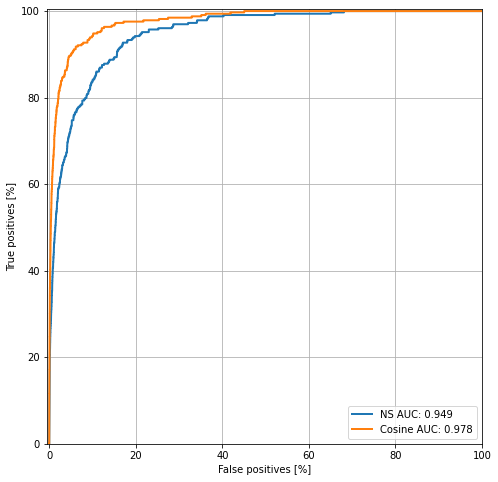

In [19]:
plt.figure(figsize=(16,8))
plot_roc("NS", y_test, y_nn_preds)
plot_roc("Cosine", y_test, y_cosine_preds)
plt.legend(loc='lower right')

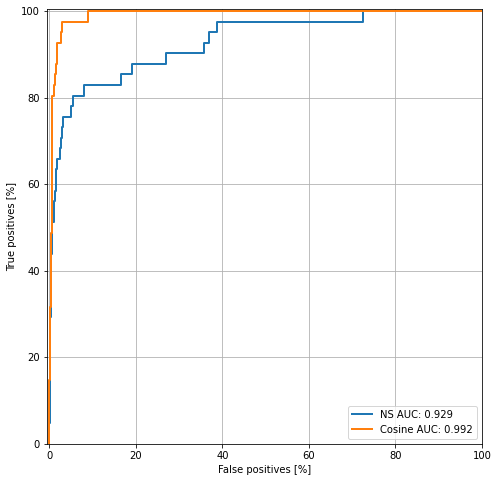

In [25]:
plt.figure(figsize=(16,8))
plot_roc("NS", y_test, y_nn_preds)
plot_roc("Cosine", y_test, y_cosine_preds)
plt.legend(loc='lower right')